In [ ]:
import torch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
transformer_train = torchvision.transforms.Compose([
  # torchvision.transforms.RandomHorizontalFlip(p=0.5),
  # torchvision.transforms.RandomAffine(0, translate=(0.1, 0.1)),
  transforms.ToTensor(),                                            
])

In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root ='.',
    train=True,
    transform = transformer_train,
    download=True,
)


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [ ]:
train_dataset.data.max()

tensor(255, dtype=torch.uint8)

In [ ]:
train_dataset.data.type()

'torch.ByteTensor'

In [ ]:
class CNN(nn.Module):
  def __init__(self,K):      
    super(CNN,self).__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(1,32,kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32,64,kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(64,64,kernel_size=3),
        nn.ReLU(),
    )

    self.fc1 = nn.Linear(64*3*3,64)
    self.fc2 = nn.Linear(64,K)
    self.drop = nn.Dropout(0.2)

  def forward(self,x):
    x = self.conv(x)
    x = x.view(x.size(0),-1)
    x = F.relu(self.fc1(x))
    x = self.drop(x)
    x = self.fc2(x)
    return x


In [ ]:
K = 10
model = CNN(K)

In [ ]:
test_dataset = torchvision.datasets.MNIST(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [ ]:
model.to(device)

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
  )
  (fc1): Linear(in_features=576, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  (drop): Dropout(p=0.2, inplace=False)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
batch_size=128
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [ ]:
n_epochs = 10

train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for it in range(n_epochs):
  train_loss=[]
  t0 = datetime.now()
  for inputs, targets in train_dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    # targets = targets.to(torch.float32)

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = criterion(outputs,targets)

    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
  train_loss = np.mean(train_loss)

  test_loss=[]
  for inputs, targets in test_dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    # targets = targets.to(torch.float32)
    outputs = model(inputs)
    loss = criterion(outputs,targets)
    test_loss.append(loss.item())
  test_loss = np.mean(test_loss)

  train_losses[it] = train_loss
  test_losses[it] = test_loss

  dt = datetime.now() - t0
  print(f'Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, \
      Test Loss: {test_loss:.4f}, Duration: {dt}')

Epoch 1/10, Train Loss: 0.3463,       Test Loss: 0.1042, Duration: 0:00:06.752216
Epoch 2/10, Train Loss: 0.0886,       Test Loss: 0.0654, Duration: 0:00:06.454911
Epoch 3/10, Train Loss: 0.0628,       Test Loss: 0.0525, Duration: 0:00:06.496868
Epoch 4/10, Train Loss: 0.0477,       Test Loss: 0.0439, Duration: 0:00:06.500605
Epoch 5/10, Train Loss: 0.0394,       Test Loss: 0.0394, Duration: 0:00:06.450650
Epoch 6/10, Train Loss: 0.0349,       Test Loss: 0.0349, Duration: 0:00:06.469327
Epoch 7/10, Train Loss: 0.0292,       Test Loss: 0.0380, Duration: 0:00:06.456918
Epoch 8/10, Train Loss: 0.0275,       Test Loss: 0.0362, Duration: 0:00:06.473680
Epoch 9/10, Train Loss: 0.0246,       Test Loss: 0.0308, Duration: 0:00:06.455907
Epoch 10/10, Train Loss: 0.0194,       Test Loss: 0.0332, Duration: 0:00:06.443933


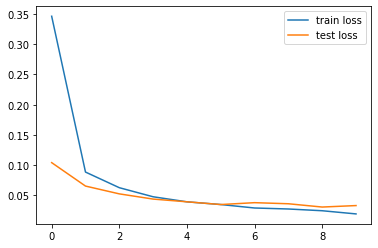

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [ ]:
n_correct = 0
n_total =0

train_acc=0
for inputs, targets in train_dataloader:
  inputs, targets = inputs.to(device),targets.to(device)
  targets = targets.to(torch.float32)

  outputs = model(inputs)
  # print(outputs)
  _,prediction = torch.max(outputs,1)    
  n_correct += (prediction==targets).sum().item()
  n_total += targets.shape[0]

  train_acc = n_correct/n_total

n_correct=0.
n_total=0.
for inputs, targets in test_dataloader:
  inputs,targets = inputs.to(device),targets.to(device)

  outputs = model(inputs)
  try:
    _,prediction = torch.max(outputs,1)
  except Exception as e:
    print(e)
    print(outputs)

  n_correct += (prediction==targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct/n_total

print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9953, Test acc: 0.9902


In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[ 974    0    1    0    0    0    1    3    1    0]
 [   0 1131    1    1    0    0    1    1    0    0]
 [   0    5 1015    4    0    0    1    6    0    1]
 [   0    0    0 1008    0    2    0    0    0    0]
 [   0    0    1    0  973    0    0    0    1    7]
 [   2    0    1   10    0  872    1    1    1    4]
 [   6    1    0    0    2    1  947    0    1    0]
 [   1    3    2    3    0    0    0 1018    0    1]
 [   1    1    1    4    0    0    0    1  964    2]
 [   0    0    0    0    2    2    0    3    6  996]]


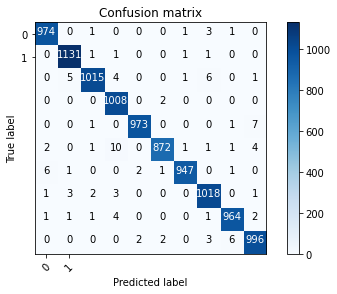

In [ ]:
y_test = test_dataset.targets

p_test = np.array([])
for inputs, targets in test_dataloader:
  # move data to GPU
  inputs = inputs.to(device)

  # Forward pass
  outputs = model(inputs)

  # Get prediction
  _, predictions = torch.max(outputs, 1)
  
  # update p_test
  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(2)))